<h1><center>PISAP: Python Interactive Sparse Astronomical Data Analysis Packages</center></h1>
<h2><center>Grid searching in PISAP tutorial</center></h2>
<div style="text-align: center">Credit: </div>

Pisap is a Python package related to sparsity and its application in
astronomical or mediacal data analysis. This package propose sparse denosing methods reusable in various contexts.
For more information please visit the project page on github: https://github.com/neurospin/pisap.<br><br>

<h3>First check</h3>

In order to test if the 'pisap' package is installed on your machine, you can check the package version:

In [1]:
import pisap
print pisap.__version__

0.0.0


<h2>Grid searching on the parameters of reconstruction</h2>

The package provides a flexible implementation of a grid search method.

<h3>Astronomical denoising</h3>

First load the toy datase and the associated sampling mask.

In [2]:
import scipy.fftpack as pfft
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from pisap.data import get_sample_data
from pisap.base.utils import convert_mask_to_locations
from pisap.numerics.noise import add_noise
from pisap.numerics.reconstruct import sparse_rec_fista
from pisap.numerics.gradient import Grad2DSynthesis
from pisap.numerics.linear import Wavelet
from pisap.numerics.fourier import FFT
from pisap.numerics.cost import psnr
from pisap.numerics.gridsearch import grid_search

In [3]:
fits_data_path = get_sample_data("astro-fits")
image = pisap.io.load(fits_data_path)
image.show()
mask_data_path = get_sample_data("astro-mask")
mask = pisap.io.load(mask_data_path)
mask.show()

Now generate a synthetic image from the previous toy_dataset and sampling mask.

In [4]:
dirty_data = add_noise(image.data, sigma=0.01, noise_type="gauss")
dirty_image = pisap.Image(data=dirty_data)
dirty_image.show()
mask_shift = pfft.ifftshift(mask.data)
localization = convert_mask_to_locations(mask_shift)
dirty_fft = mask_shift * pfft.fft2(dirty_image.data)

Now run the denoising algoritm with custom gradient and linear operator using a positivity constraint.

In [5]:
metrics = {'psnr':{'metric':psnr,
                  'mapping': {'x_new': 'test', 'y_new':None},
                  'cst_kwargs':{'ref':image.data},
                  'early_stopping': True,
                   },
           }
params = {
    'data':dirty_fft,
    'gradient_cls':Grad2DSynthesis,
    'gradient_kwargs':{"ft_cls": {FFT: {"samples_locations": localization,
                                        "img_size": dirty_fft.shape[0]}}},
    'linear_cls':Wavelet,
    'linear_kwargs':[{"nb_scale": 2, "wavelet": "MallatWaveletTransform79Filters"},
                     {"nb_scale": 3, "wavelet": "MallatWaveletTransform79Filters"},
                    ],
    'max_nb_of_iter':100,
    'mu':[3.0e-4, 5.0e-4, 6.0e-4, 7.0e-4, 8.0e-4],
    'metrics':metrics,
    'verbose':0,
}
list_kwargs, results = grid_search(sparse_rec_fista, params,n_jobs=-1, verbose=0)

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


In [6]:
last_psnr = []
for res in results:
    last_psnr.append(res[2]['psnr']['values'][-1])
last_psnr = np.array(last_psnr)
best_psnr = last_psnr.max()
best_idx = last_psnr.argmax()
best_params = list_kwargs[best_idx]
best_image = results[best_idx][0]

In [7]:
print("Best SNR: {0}".format(best_psnr))
print("-> associated wavelet parameters: {0}".format(best_params['linear_kwargs']))
print("-> associated regu. parameters: {0}".format(best_params['mu']))

Best SNR: 38.8094325021
-> associated wavelet parameters: {'nb_scale': 2, 'wavelet': 'MallatWaveletTransform79Filters'}
-> associated regu. parameters: 0.0006


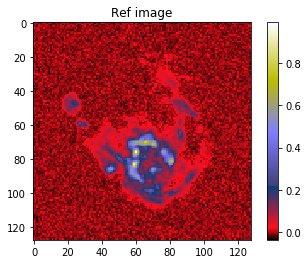

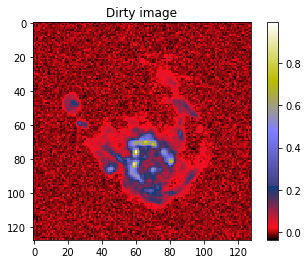

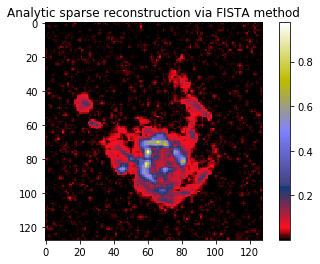

In [8]:
plt.figure()
plt.imshow(image.data, interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Ref image")

plt.figure()
plt.imshow(dirty_image.data, interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Dirty image")

plt.figure()
plt.imshow(np.abs(best_image.data), interpolation="nearest", cmap="gist_stern")
plt.colorbar()
plt.title("Analytic sparse reconstruction via FISTA method")
plt.show()